In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marcopinamonti/alzheimer-mri-4-classes-dataset")

print("Path to dataset files:", path)

100%|██████████| 34.1M/34.1M [00:00<00:00, 52.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset/versions/1


In [2]:
# Import necessary libraries
import zipfile
import os

# Specify the path to the uploaded zip file
zip_file_path = "/content/archive.zip"  # Update the file name if different

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/alzheimers_dataset")  # Destination folder

# Verify extraction
print("Dataset extracted to /content/alzheimers_dataset")

Dataset extracted to /content/alzheimers_dataset


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [7]:
DATASET_DIR = "/content/alzheimers_dataset/Alzheimer_MRI_4_classes_dataset"
CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
IMG_SIZE = (224, 224)

In [8]:
def load_images_from_directory(dataset_dir, classes, img_size):
    images, labels = [], []
    for idx, label in enumerate(classes):
        class_dir = os.path.join(dataset_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                img = cv2.resize(img, img_size)  # Resize to 224x224
                images.append(img)
                labels.append(idx)  # Numeric label
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)


In [9]:
X, y = load_images_from_directory(DATASET_DIR, CLASSES, IMG_SIZE)

# Normalize pixel values
X = X / 255.0  # Scale to [0, 1]

# Reshape for CNN input
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)  # Add channel dimension

# One-hot encode labels
y = to_categorical(y, num_classes=len(CLASSES))

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 4480
Validation samples: 960
Test samples: 960


In [10]:
def create_cnn(input_shape):
    input_layer = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    return input_layer, x

In [11]:
def build_ann(input_shape, num_classes):
    cnn_input, cnn_output = create_cnn(input_shape)

    # Output layer
    output = Dense(num_classes, activation='softmax')(cnn_output)

    # Model
    model = Model(inputs=cnn_input, outputs=output)
    return model


In [12]:
# Define input shape
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)  # 224x224 grayscale images

# Build the model
model = build_ann(input_shape=input_shape, num_classes=len(CLASSES))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,709,572 (98.07 MB)

 Trainable params: 25,709,572 (98.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.4748 - loss: 1.6532 - val_accuracy: 0.5365 - val_loss: 0.9418
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5208 - loss: 0.9788 - val_accuracy: 0.5979 - val_loss: 0.8787
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6070 - loss: 0.8462 - val_accuracy: 0.7302 - val_loss: 0.6738
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7485 - loss: 0.6185 - val_accuracy: 0.8323 - val_loss: 0.4389
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8705 - loss: 0.3467 - val_accuracy: 0.8906 - val_loss: 0.2583
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9459 - loss: 0.1599 - val_accuracy: 0.9458 - val_loss: 0.1615
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9695 - loss: 0.0943 - val_accuracy: 0.9615 - val_loss: 0.1102
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9809 - loss: 0.0601 - val_

In [14]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9710 - loss: 0.1652
Test Accuracy: 97.29%
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
                  precision    recall  f1-score   support

    MildDemented       1.00      0.97      0.98       156
ModerateDemented       1.00      1.00      1.00         6
     NonDemented       0.97      0.99      0.98       479
VeryMildDemented       0.97      0.95      0.96       319

        accuracy                           0.97       960
       macro avg       0.98      0.98      0.98       960
    weighted avg       0.97      0.97      0.97       960

Confusion Matrix:
[[151   0   1   4]
 [  0   6   0   0]
 [  0   0 474   5]
 [  0   0  16 303]]


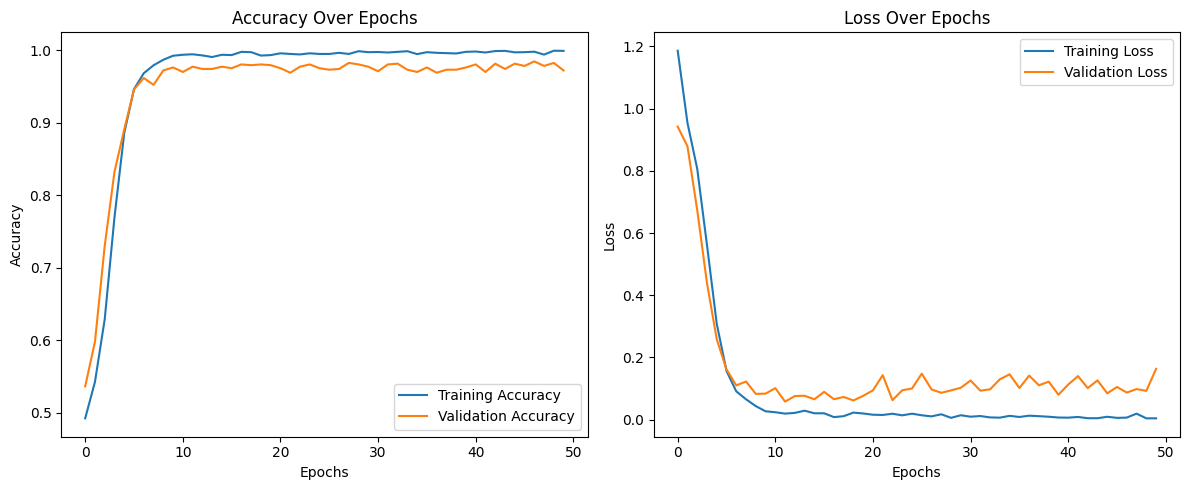

In [15]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
!pip install tf-keras-vis
from tensorflow.keras import backend as K
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam

# Grad-CAM visualization
def gradcam_visualization(image, model, class_index):
    gradcam = Gradcam(model=model)
    score = CategoricalScore(class_index)  # Class index for Grad-CAM
    cam = gradcam(score, image[np.newaxis])
    plt.imshow(cam[0], cmap='jet')
    plt.title(f'Grad-CAM for class {class_index}')
    plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.8 MB/s eta 0:00:00
